In [1]:
import sys
import os
import subprocess
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib notebook # for interactive plots
# %matplotlib inline

import cProfile
# from line_profiler import LineProfiler

# Add the path to housing_app to the Python path, if it's not in the folder
# TODO: Adjust the path to match the local location of housing_app
# sys.path.append('/Users/k4robins/Devel/0_Thesis/housing_app')
# from housing_app.model.model import City

# Alternatively, if the housing_app is in the current folder, directly import it
from model.model import City

In [2]:
# Set parameter values and run simulation
# Do param sweep with gamma (exponential), A and price (quadratic together)
num_steps  = 30
parameters = {
            'run_notes': 'Debugging model.',
            'subfolder': None,
            'width': 50,
            'height': 1,
            'init_city_extent': 10.,  # f CUT OR CHANGE?
            'seed_population': 400,
            'density': 100,
            'subsistence_wage': 40000.,  # psi
            'init_wage_premium_ratio': 0.2, # 1.2, ###
            'A': 2000,                             ###
            'alpha': 0.18,
            'beta':  0.71,                         #####
            'gamma': 0.14,
            'price_of_output': 3.,                 ######
            'overhead': 2,
            'mult': 1.2,
            'c': 200.0,
            'adjN': 0.15,
            'adjk': 0.15,
            'adjn': 0.25,
            'adjF': 0.15,
            'init_agglomeration_population': 0.0,
            'init_F': 100.0,
            'init_k': 100.0,
            'init_n': 100.0,
            'r_prime': 0.05,  # 0.03
            'mortgage_period': 5.0,  # T, in years
            'working_periods': 40,  # in years
            'savings_rate': 0.3,
            'discount_rate': 0.07, # 1/delta
            'r_margin': 0.01,
            'property_tax_rate': 0.04,  # tau, annual rate, was c
            'housing_services_share': 0.3,  # a
            'maintenance_share': 0.2,  # b
            'max_mortgage_share': 0.9,
            'ability_to_carry_mortgage': 0.28,
            'wealth_sensitivity': 0.1,
        }

def run_simulation(num_steps, parameters):
    city = City(num_steps, **parameters)
    city.run_model()

    agent_out = city.datacollector.get_agent_vars_dataframe()
    model_out = city.datacollector.get_model_vars_dataframe()
    return agent_out, model_out


agent_out, model_out = run_simulation(num_steps, parameters)

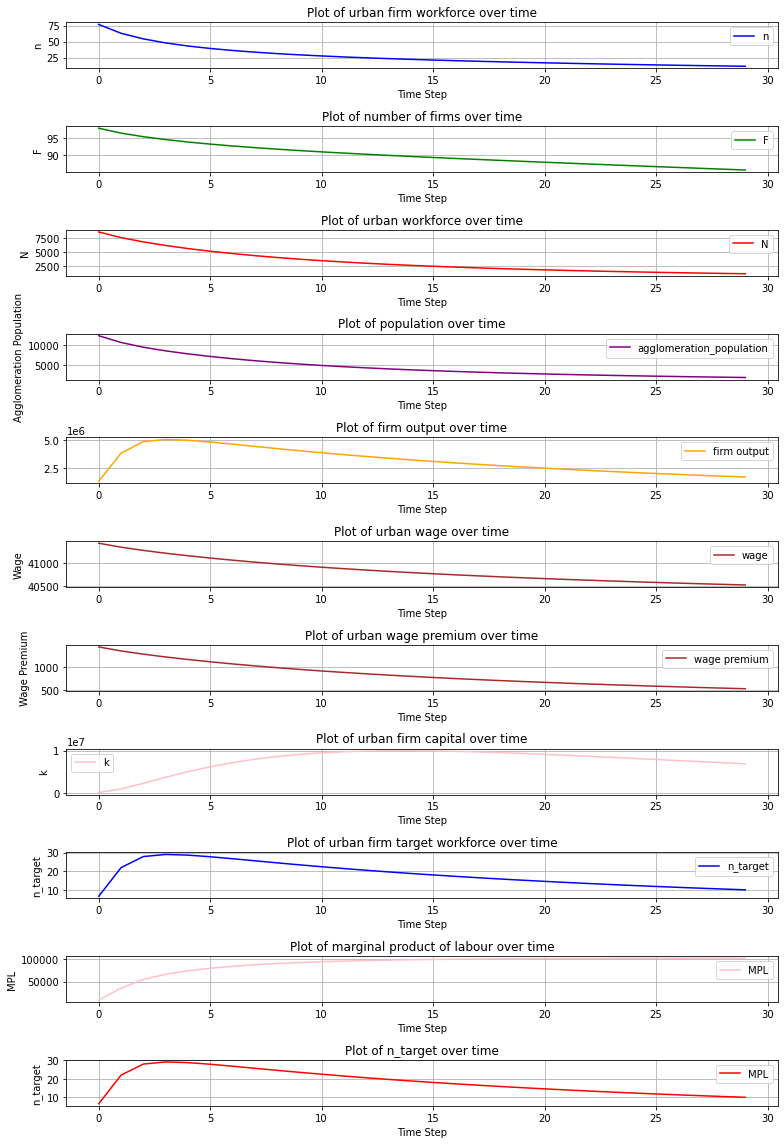

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Create a time array for the x-axis
time = np.arange(len(model_out['workers']))

# Create subplots with increased spacing
fig, axes = plt.subplots(11, 1, figsize=(11, 16))

# Adjust subplot spacing
fig.subplots_adjust(hspace=0.5)

# Plot n
axes[0].plot(time, model_out['n'], label='n', color='blue')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('n')
axes[0].set_title('Plot of urban firm workforce over time')
axes[0].grid(True)
axes[0].legend()

# Plot n_target
axes[8].plot(time, model_out['n_target'], label='n_target', color='blue')
axes[8].set_xlabel('Time Step')
axes[8].set_ylabel('n_target')
axes[8].set_title('Plot of urban firm target workforce over time')
axes[8].grid(True)
axes[8].legend()

# Plot F
axes[1].plot(time, model_out['F'], label='F', color='green')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('F')
axes[1].set_title('Plot of number of firms over time')
axes[1].grid(True)
axes[1].legend()

# Plot N
axes[2].plot(time, model_out['N'], label='N', color='red')
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('N')
axes[2].set_title('Plot of urban workforce over time')
axes[2].grid(True)
axes[2].legend()

# Plot Urban population
axes[3].plot(time, model_out['agglomeration_population'], label='agglomeration_population', color='purple')
axes[3].set_xlabel('Time Step')
axes[3].set_ylabel('Agglomeration Population')
axes[3].set_title('Plot of population over time')
axes[3].grid(True)
axes[3].legend()

# Plot y   ####   #3  HAD NO EFFECT
# Y = parameters['price_of_output'] * model_out['A_F'] * (parameters['mult'] * model_out['N'] + parameters['seed_population']) ** parameters['gamma'] * model_out['k'] ** parameters['alpha_F'] * model_out['n'] ** parameters['beta_F']
axes[4].plot(time, model_out['y'], label='firm output', color='orange')
axes[4].set_xlabel('Time Step')
axes[4].set_ylabel('')
axes[4].set_title('Plot of firm output over time')
axes[4].grid(True)
axes[4].legend()

# Plot w    #  #### #4 change wage premium to wage   Wage premium behaves wrongly. wage behaves sensibly
axes[5].plot(time, model_out['wage'], label='wage', color='brown')
axes[5].set_xlabel('Time Step')
axes[5].set_ylabel('Wage')
axes[5].set_title('Plot of urban wage over time')
axes[5].grid(True)
axes[5].legend()

# Plot w    #  #### #4 change wage premium to wage   Wage premium behaves wrongly.Is 1/10 of needed size dsoes not respond to changing thepagepremium ratio
axes[6].plot(time, model_out['wage_premium'], label='wage premium', color='brown')
axes[6].set_xlabel('Time Step')
axes[6].set_ylabel('Wage Premium')
axes[6].set_title('Plot of urban wage premium over time')
axes[6].grid(True)
axes[6].legend()

# Plot k
axes[7].plot(time, model_out['k'], label='k', color='pink')
axes[7].set_xlabel('Time Step')
axes[7].set_ylabel('k')
axes[7].set_title('Plot of urban firm capital over time')
axes[7].grid(True)
axes[7].legend()

# Plot MPL   ####  # 5 new  COMPLETELY MISSING!!
axes[9].plot(time, model_out['MPL'], label='MPL', color='pink')
axes[9].set_xlabel('Time Step')
axes[9].set_ylabel('MPL')
axes[9].set_title('Plot of marginal product of labour over time')
axes[9].grid(True)
axes[9].legend()

# Plot n_target  
axes[10].plot(time, model_out['n_target'], label='MPL', color='red')
axes[10].set_xlabel('Time Step')
axes[10].set_ylabel('n_target')
axes[10].set_title('Plot of n_target over time')
axes[10].grid(True)
axes[10].legend()


plt.tight_layout()
plt.show()

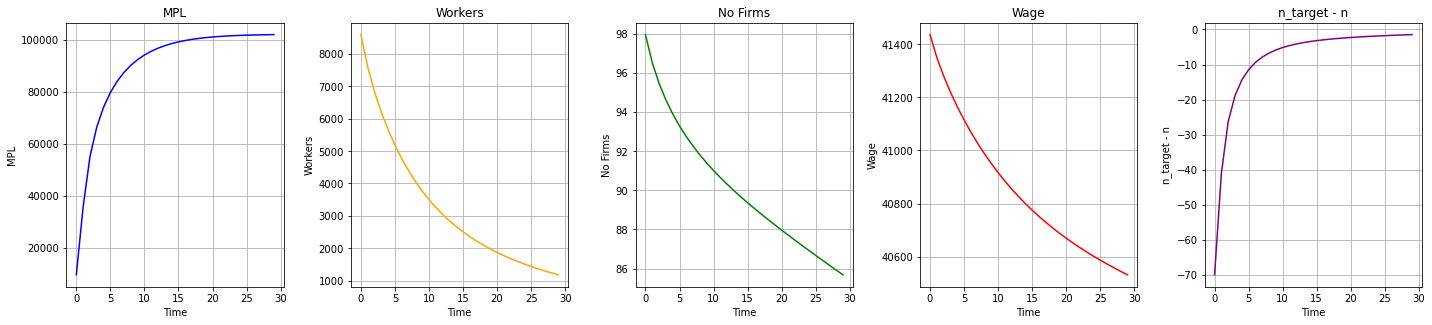

In [4]:
def plot_selected_model_out_keys(model_out):
    time = np.arange(len(model_out['workers']))

    # Set up the figure with subplots
    num_cols = 5  # Number of columns in the grid
    num_rows = 1  # Number of rows in the grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))
    # fig.suptitle('Selected Model Output', fontsize=16)

    # Plot selected variables
    mpl = np.array(model_out['MPL'])
    workers = np.array(model_out['workers'])
    no_firms = np.array(model_out['F'])
    wage = np.array(model_out['wage'])
    ntarget_vs_n = np.array(model_out['n_target']) - np.array(model_out['n'])

    axes[0].plot(time, mpl, color='blue')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('MPL')
    axes[0].set_title('MPL')
    axes[0].grid(True)

    axes[1].plot(time, workers, color='orange')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Workers')
    axes[1].set_title('Workers')
    axes[1].grid(True)

    axes[2].plot(time, no_firms, color='green')
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('No Firms')
    axes[2].set_title('No Firms')
    axes[2].grid(True)

    axes[3].plot(time, wage, color='red')
    axes[3].set_xlabel('Time')
    axes[3].set_ylabel('Wage')
    axes[3].set_title('Wage')
    axes[3].grid(True)

    axes[4].plot(time, ntarget_vs_n, color='purple')
    axes[4].set_xlabel('Time')
    axes[4].set_ylabel('n_target - n')
    axes[4].set_title('n_target - n')
    axes[4].grid(True)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_selected_model_out_keys(model_out)

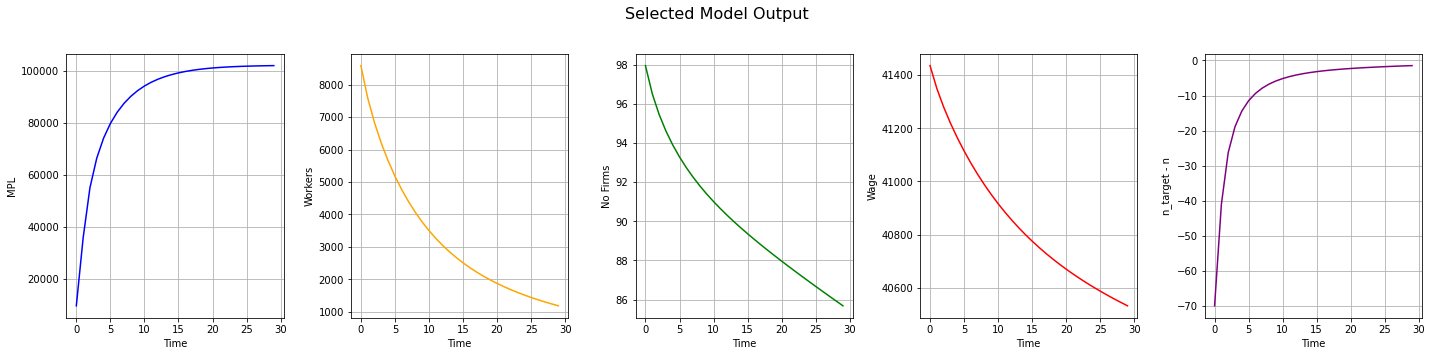

In [5]:
def plot_selected_model_out_keys(model_out):
    time = np.arange(len(model_out['workers']))

    # Set up the figure with subplots
    num_cols = 5  # Number of columns in the grid
    num_rows = 1  # Number of rows in the grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))
    fig.suptitle('Selected Model Output', fontsize=16)

    # Plot selected variables
    mpl = np.array(model_out['MPL'])
    workers = np.array(model_out['workers'])
    no_firms = np.array(model_out['F'])
    wage = np.array(model_out['wage'])
    ntarget_vs_n = np.array(model_out['n_target']) - np.array(model_out['n'])

    axes[0].plot(time, mpl, color='blue')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('MPL')
    axes[0].grid(True)

    axes[1].plot(time, workers, color='orange')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Workers')
    axes[1].grid(True)

    axes[2].plot(time, no_firms, color='green')
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('No Firms')
    axes[2].grid(True)

    axes[3].plot(time, wage, color='red')
    axes[3].set_xlabel('Time')
    axes[3].set_ylabel('Wage')
    axes[3].grid(True)

    axes[4].plot(time, ntarget_vs_n, color='purple')
    axes[4].set_xlabel('Time')
    axes[4].set_ylabel('n_target - n')
    axes[4].grid(True)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_selected_model_out_keys(model_out)

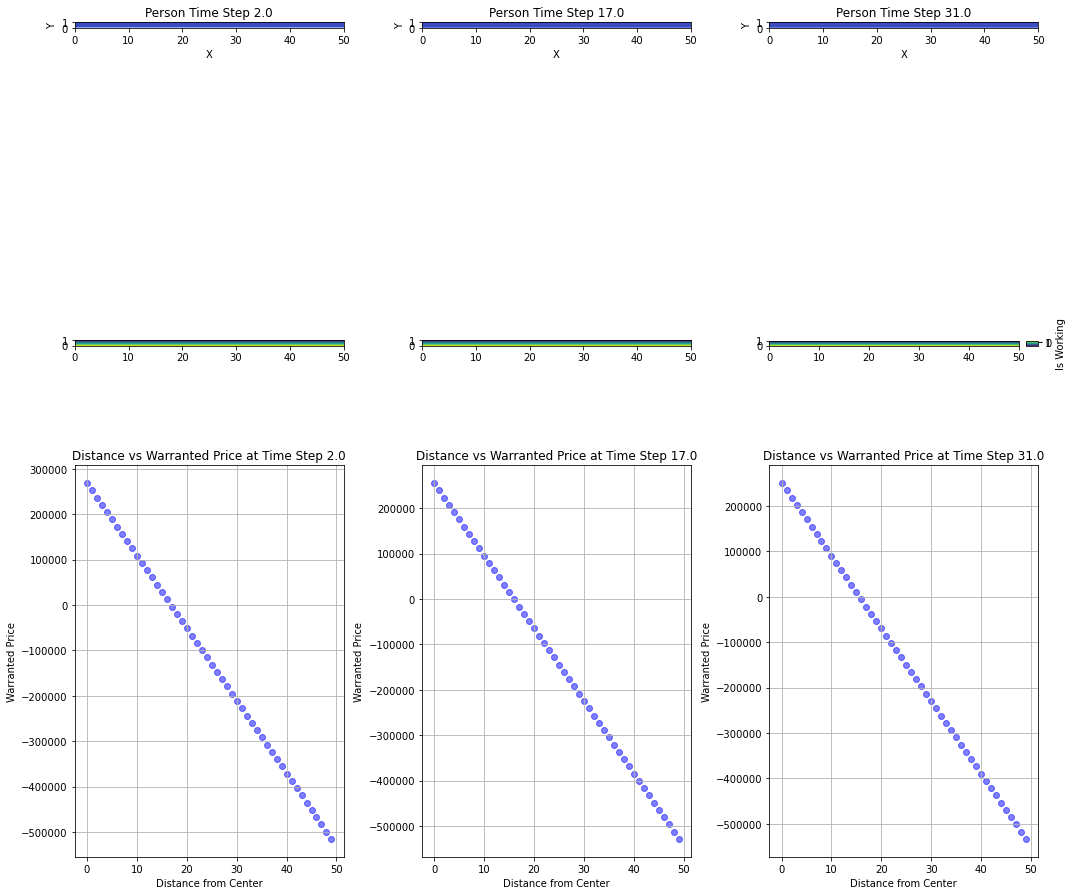

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Filter agent_out data for Person agents
person_df = agent_out.query("agent_type == 'Person'")
person_df = person_df.dropna(axis=1, how='all').reset_index(drop=True)
person_df = person_df.reset_index(drop=True)

# Filter agent_out data for Land agents
land_df = agent_out.query("agent_type == 'Land'")
land_df = land_df.dropna(axis=1, how='all').reset_index(drop=True)
land_df = land_df.reset_index(drop=True)

# Get the range of time steps
person_time_steps = person_df['time_step'].unique()
num_person_time_steps = len(person_time_steps)
person_middle_time_step = person_time_steps[num_person_time_steps // 2]

# Create subplots with 3 rows and 3 columns
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over the subplots and time steps for Person data
for i, time_step in enumerate([person_time_steps[0], person_middle_time_step, person_time_steps[-1]]):
    person_agents = person_df.query("time_step == @time_step")
    
    # Create a grid to represent the space
    grid_size = (person_df['x'].max() + 1, person_df['y'].max() + 1)
    heatmap = np.zeros(grid_size)
    
    # Fill the heatmap with the 'is_working' values
    for index, row in person_agents.iterrows():
        x = int(row['x'])
        y = int(row['y'])
        is_working = row['is_working']
        heatmap[x, y] = is_working
    
    # Display the heatmap in the current subplot
    im = axs[0, i].imshow(heatmap, cmap='coolwarm', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]], vmin=0, vmax=1)
    axs[0, i].set_title(f'Person Time Step {time_step}')
    axs[0, i].set_xlabel('X')
    axs[0, i].set_ylabel('Y')
    axs[0, i].grid(False)

# Iterate over the subplots and time steps for Land data
for i, time_step in enumerate([person_time_steps[0], person_middle_time_step, person_time_steps[-1]]):
    land_agents = land_df.query("time_step == @time_step")
    
    # Create a grid to represent the space
    grid_size = (land_df['x'].max() + 1, land_df['y'].max() + 1)
    heatmap = np.zeros(grid_size)
    
    # Fill the heatmap with the values
    for index, row in land_agents.iterrows():
        x = int(row['x'])
        y = int(row['y'])
        price = row['warranted_price']
        heatmap[x, y] = price
    
    # Display the heatmap in the current subplot
    im = axs[1, i].imshow(heatmap, cmap='viridis', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]]) #, vmin=min_price, vmax=max_price)
    axs[1, i].grid(False)
    
    # Create scatter plot for distance from center vs warranted price
    scatter = axs[2, i].scatter(land_agents['distance_from_center'], land_agents['warranted_price'], c='blue', alpha=0.5)
    axs[2, i].set_title(f'Distance vs Warranted Price at Time Step {time_step}')
    axs[2, i].set_xlabel('Distance from Center')
    axs[2, i].set_ylabel('Warranted Price')
    axs[2, i].grid(True)
    
    # Set same min and max values for scatter plots
    # axs[2, i].set_ylim(min_price, max_price)

# Add a common colorbar
divider = make_axes_locatable(axs[1, 2])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax, ticks=[0, 1])
cbar.set_label('Is Working')

plt.tight_layout()
plt.show()

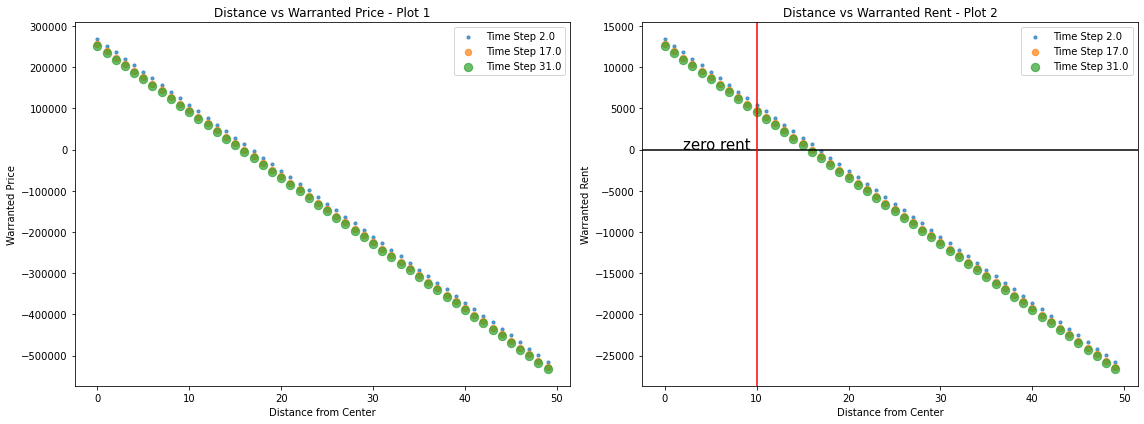

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Filter agent_out data for Land agents
df = agent_out.query("agent_type == 'Land'")
df = df.dropna(axis=1, how='all').reset_index(drop=True)
df = df.reset_index(drop=True)

# Get the range of time steps
time_steps = df['time_step'].unique()
middle_time_step = time_steps[len(time_steps) // 2]

# Calculate min and max dot sizes
min_dot_size = 10
max_dot_size = 70

# Create a scatter plot with three dots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Create two subplots side by side

for ax_index, ax in enumerate(axs):
    # Create dots for the three selected time steps
    for i, time_step in enumerate([time_steps[0], middle_time_step, time_steps[-1]]):
        land_agents = df.query("time_step == @time_step")

        # Calculate dot size based on time step
        normalized_dot_size = (time_step - min(time_steps)) / (max(time_steps) - min(time_steps))
        dot_size = min_dot_size + (max_dot_size - min_dot_size) * normalized_dot_size

        # Determine which variable to plot based on subplot index
        if ax_index == 0:
            y_variable = 'warranted_price'
        else:
            y_variable = 'warranted_rent'

        # Create scatter plot for distance from center vs warranted_price or warranted_rent
        ax.scatter(land_agents['distance_from_center'], land_agents[y_variable], label=f'Time Step {time_step}', alpha=0.7, s=dot_size)

    # Set labels and title for each subplot
    ax.set_xlabel('Distance from Center')
    ax.set_ylabel(y_variable.replace('_', ' ').title())  # Format ylabel
    ax.set_title(f'Distance vs {y_variable.replace("_", " ").title()} - Plot {ax_index + 1}')
    ax.legend()

plt.tight_layout()
                 
# Add horizontal and vertical reference lines
plt.axhline(y = 0, xmin = 0., color ='black')# zero 
plt.axvline(x = 10, ymin = 0., color ='red')
plt.text(2, 6, r'zero rent', fontsize=15)

plt.show()

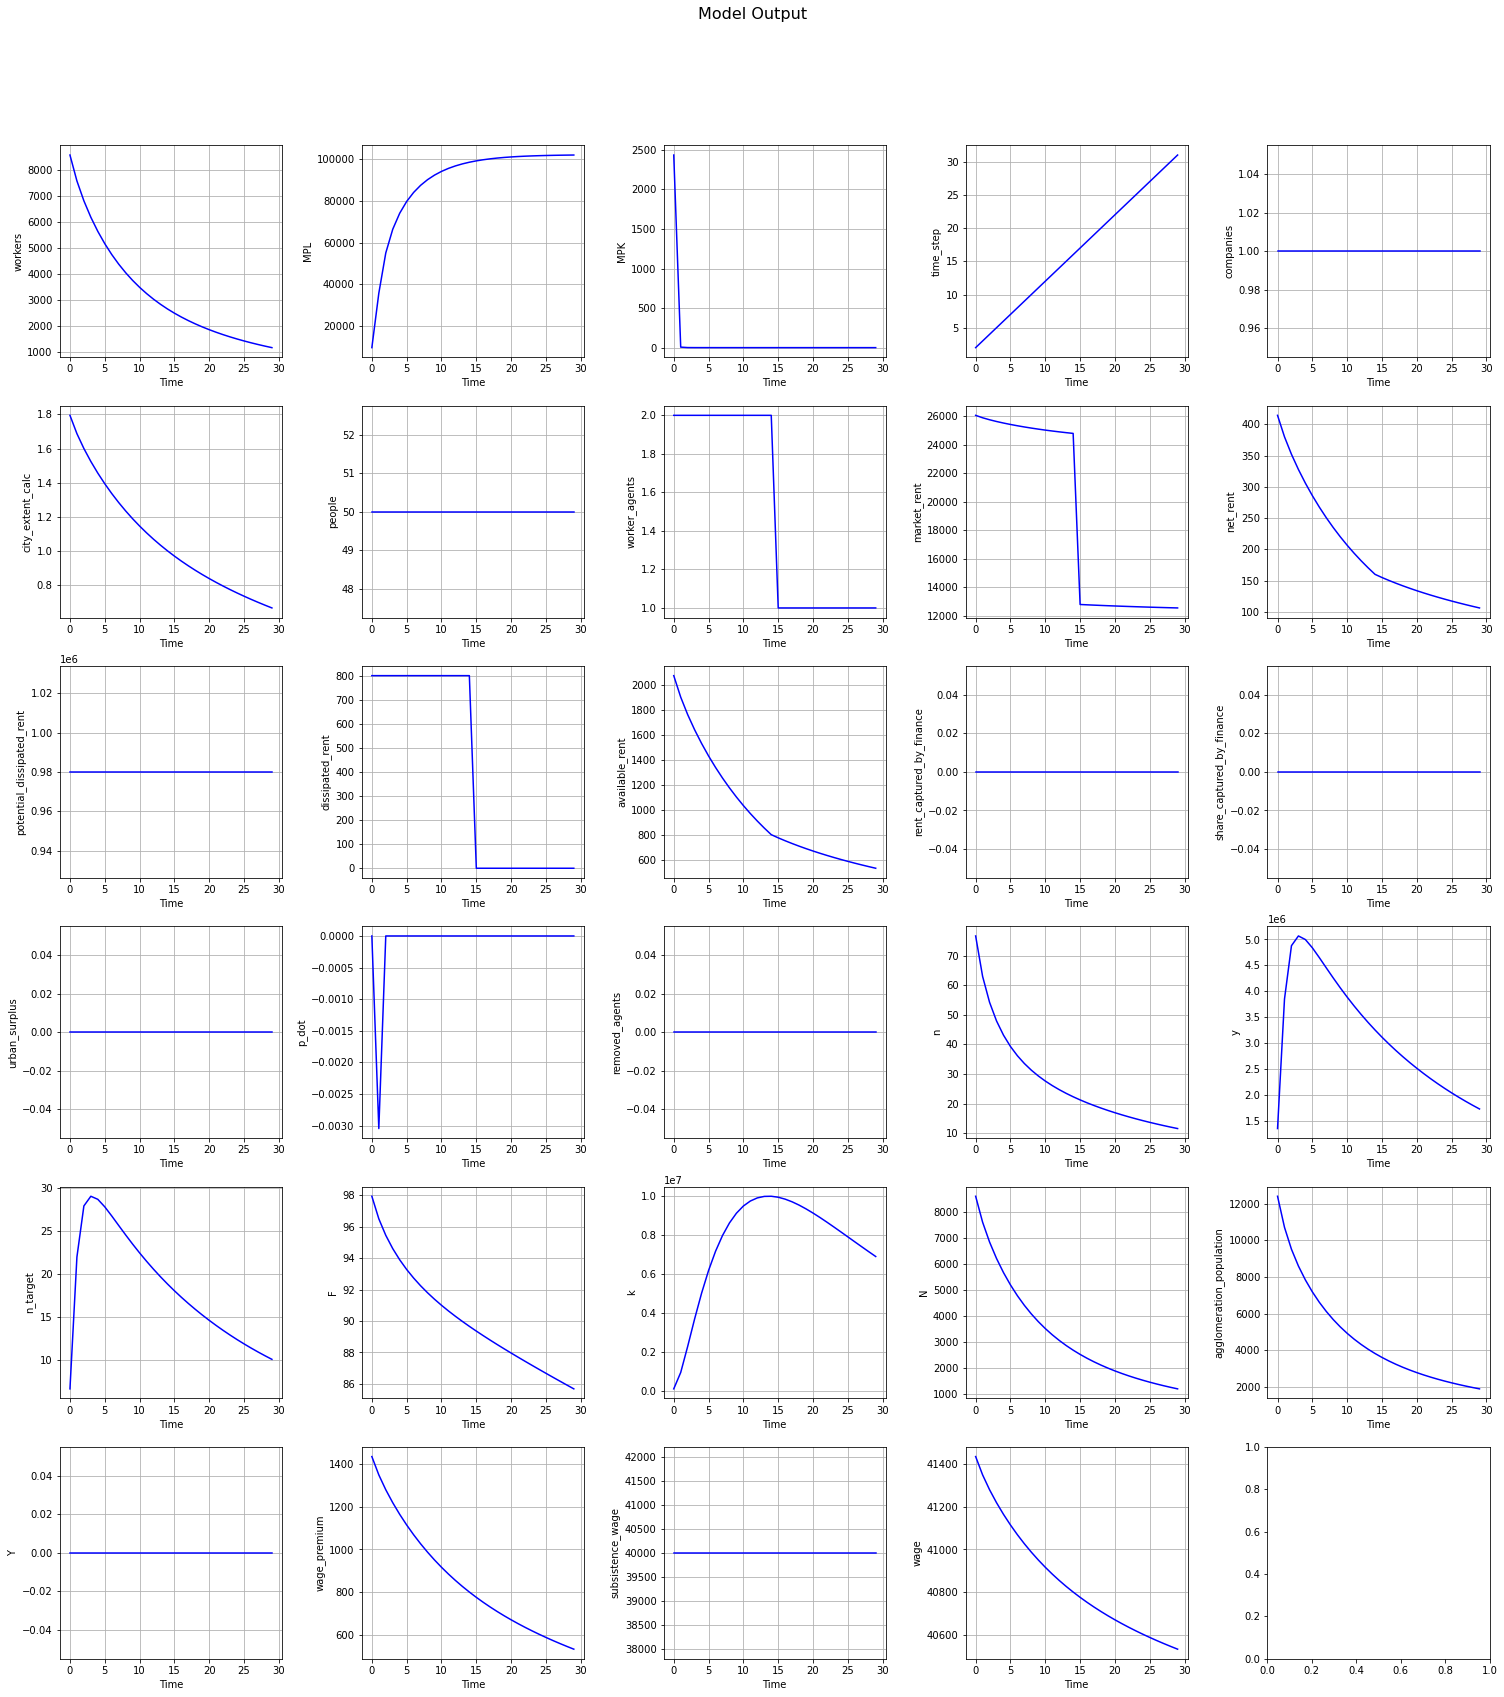

In [8]:
# Plot all model_out variables
def plot_all_model_out_keys(model_out):
    time = np.arange(len(model_out['workers']))

    # Set up the figure with subplots
    num_keys = len(model_out.keys())
    num_cols = 5  # Number of columns in the grid
    num_rows = (num_keys + num_cols - 1) // num_cols  # Calculate the number of rows needed
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(21, 4 * num_rows))
    fig.suptitle('Model Output', fontsize=16)

    # Plot each model_out key
    model_out_keys = list(model_out.keys())
    for i, ax in enumerate(axes.ravel()):
        if i < len(model_out_keys):
            model_out_key = model_out_keys[i]
            variable = np.array(model_out[model_out_key])
            ax.plot(time, variable, color='blue')
            ax.set_xlabel('Time')
            ax.set_ylabel(model_out_key)
            ax.grid(True)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
plot_all_model_out_keys(model_out)

In [9]:
# # Plot just named variables
# def plot_named_variables(model_out, model_out_keys):
#     time = np.arange(len(model_out['workers']))

#     # Set up the figure with subplots
#     fig, axes = plt.subplots(4, 5, figsize=(21, 15))
#     fig.suptitle('Model Output', fontsize=16)

#     # Plot each model_out key
#     for i, ax in enumerate(axes.ravel()):
#         if i < len(model_out_keys):
#             model_out_key = model_out_keys[i]
#             variable = np.array(model_out[model_out_key])
#             ax.plot(time, variable, color='blue')
#             ax.set_xlabel('Time')
#             ax.set_ylabel(model_out_key)
#             ax.grid(True)

#     plt.tight_layout()
#     plt.subplots_adjust(top=0.9)
#     plt.show()

# model_out_keys = ['MPL', 'MPK', 'F_next_total', 'F', 'n', 'y', 'n_target', 'y_target', 'N_target_total', 'k', 'adj_f', 'F_target', 'F_next', 'A_F']
# plot_named_variables(model_out, model_out_keys)

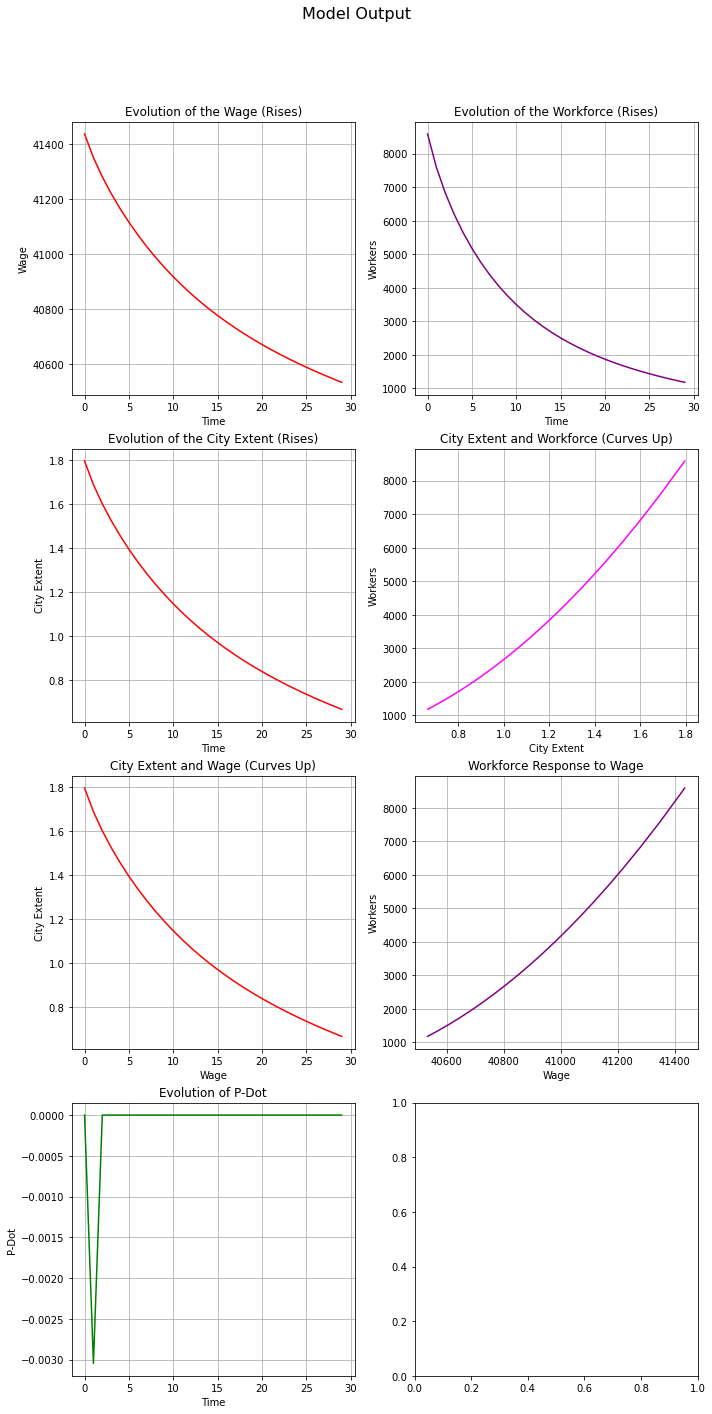

In [10]:
def plot_model_data(model_out):
    workers = np.array(model_out['workers'])
    wage_premium = np.array(model_out['wage_premium'])
    wage    = np.array(model_out['wage'])
    city_extent_calc = np.array(model_out['city_extent_calc'])
    p_dot   = np.array(model_out['p_dot'])
    time    = np.arange(len(workers))

#     # Extract additional variables from model_out
#     n = np.array(model_out['n'])
#     y = np.array(model_out['y'])
#     MPL = np.array(model_out['MPL'])
#     MPK = np.array(model_out['MPK'])
#     n_target = np.array(model_out['n_target'])
#     y_target = np.array(model_out['y_target'])
#     k_target = np.array(model_out['k_target'])
#     adj_f = np.array(model_out['adj_f'])
#     F_target = np.array(model_out['F_target'])
#     F_next = np.array(model_out['F_next'])
#     N_target_total = np.array(model_out['N_target_total'])
#     F_next_total = np.array(model_out['F_next_total'])
#     F = np.array(model_out['F'])
#     k = np.array(model_out['k'])

    fig, axes = plt.subplots(4, 2, figsize=(10, 20))
    fig.suptitle('Model Output', fontsize=16)

    # Subplot 0L: Evolution of the Wage  
    axes[0, 0].plot(time, wage, color='red')
    axes[0, 0].set_title('Evolution of the Wage (Rises)')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Wage')
    axes[0, 0].grid(True)

    # Subplot 0R: Evolution of the Workforce
    axes[0, 1].plot(time, workers, color='purple') 
    axes[0, 1].set_title('Evolution of the Workforce (Rises)')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Workers')
    axes[0, 1].grid(True)

    # Subplot 1L: Evolution of the City Extent
    axes[1,0].plot(time, city_extent_calc, color='red')
    axes[1,0].set_title('Evolution of the City Extent (Rises)')
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_ylabel('City Extent')
    axes[1,0].grid(True)

    # Subplot 1R: City Extent and Workforce  
    axes[1, 1].plot(city_extent_calc, workers, color='magenta')
    axes[1, 1].set_title('City Extent and Workforce (Curves Up)')
    axes[1, 1].set_xlabel('City Extent')
    axes[1, 1].set_ylabel('Workers')
    axes[1, 1].grid(True)              
    
    # Subplot 2L: City Extent and Wage
    axes[2, 0].plot(time, city_extent_calc, color='red')
    axes[2, 0].set_title('City Extent and Wage (Curves Up)')
    axes[2, 0].set_xlabel('Wage')
    axes[2, 0].set_ylabel('City Extent')
    axes[2, 0].grid(True)

    # Subplot 2R: Workforce Response to Wage
    axes[2, 1].plot(wage, workers, color='purple')
    axes[2, 1].set_title('Workforce Response to Wage')
    axes[2, 1].set_xlabel('Wage')
    axes[2, 1].set_ylabel('Workers')
    axes[2, 1].grid(True)

    # Subplot 3L: Evolution of P_Dot
    axes[3, 0].plot(time, p_dot, color='green')
    axes[3, 0].set_title('Evolution of P-Dot')
    axes[3, 0].set_xlabel('Time')
    axes[3, 0].set_ylabel('P-Dot')
    axes[3, 0].grid(True)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
plot_model_data(model_out)

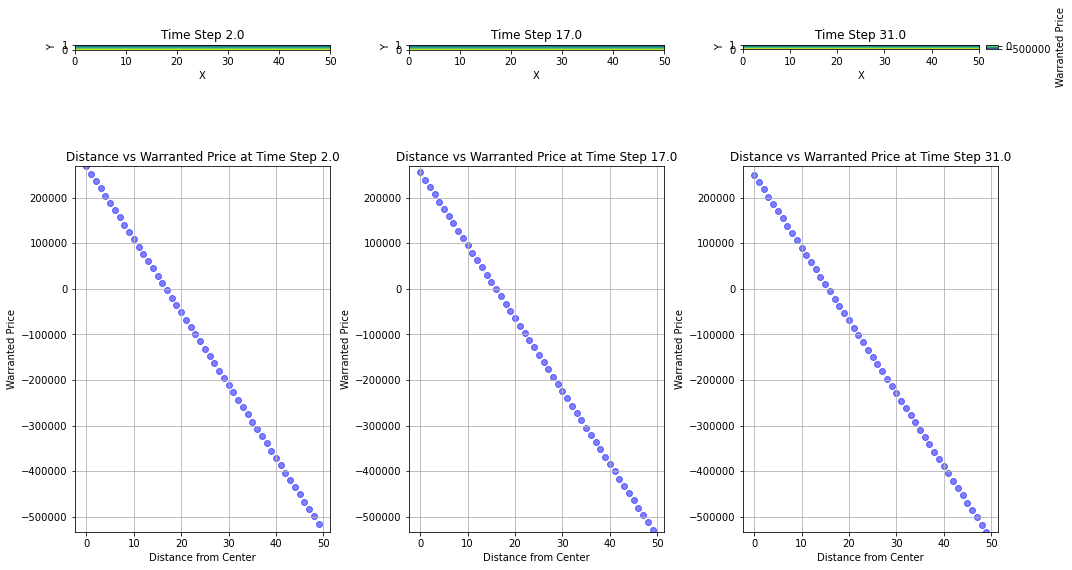

In [11]:
# Filter agent_out data for Land agents
df = agent_out.query("agent_type == 'Land'")
df = df.dropna(axis=1, how='all').reset_index(drop=True)
df = df.reset_index(drop=True)

# Get the range of time steps
time_steps = df['time_step'].unique()
num_time_steps = len(time_steps)
middle_time_step = time_steps[num_time_steps // 2]

# Find the overall min and max values for the color scale
min_price = df['warranted_price'].min()
max_price = df['warranted_price'].max()

# Create subplots with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Create a common colorbar axis
divider = make_axes_locatable(axs[0, -1])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Iterate over the subplots and time steps
for i, time_step in enumerate([time_steps[0], middle_time_step, time_steps[-1]]):
    land_agents = df.query("time_step == @time_step")
    
    # Create a grid to represent the space
    grid_size = (df['x'].max() + 1, df['y'].max() + 1)
    heatmap = np.zeros(grid_size)
    
    # Fill the heatmap with the values
    for index, row in land_agents.iterrows():
        x = int(row['x'])
        y = int(row['y'])
        price = row['warranted_price']
        heatmap[x, y] = price
    
    # Display the heatmap in the current subplot
    im = axs[0, i].imshow(heatmap, cmap='viridis', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]], vmin=min_price, vmax=max_price)
    axs[0, i].set_title(f'Time Step {time_step}')
    axs[0, i].set_xlabel('X')
    axs[0, i].set_ylabel('Y')
    axs[0, i].grid(False)
    
    # Create scatter plot for distance from center vs warranted price
    scatter = axs[1, i].scatter(land_agents['distance_from_center'], land_agents['warranted_price'], c='blue', alpha=0.5)
    axs[1, i].set_title(f'Distance vs Warranted Price at Time Step {time_step}')
    axs[1, i].set_xlabel('Distance from Center')
    axs[1, i].set_ylabel('Warranted Price')
    axs[1, i].grid(True)
    
    # Set same min and max values for scatter plots
    axs[1, i].set_ylim(min_price, max_price)

# Add a common colorbar
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Warranted Price')

plt.tight_layout()
plt.show()

### Model execution alternatives

In [12]:
# # Run with profiling
# # Function profiling
# def run_simulation(num_steps, parameters):
#     city = City(num_steps, **parameters)

#     profiler = cProfile.Profile()
#     profiler.enable()

#     city.run_model()

#     profiler.disable()
#     profiler.print_stats(sort='cumulative')
    
#     agent_out = city.datacollector.get_agent_vars_dataframe()
#     model_out = city.datacollector.get_model_vars_dataframe()
#     return agent_out, model_out

# # Line profiling
# def run_simulation(num_steps, parameters):
#     city = City(num_steps, **parameters)
#     profiler = LineProfiler()

# #     profiler.add_function(city.run_model)
# #     profiler.add_function(city.datacollector.get_agent_vars_dataframe)
# #     profiler.add_function(city.datacollector.get_model_vars_dataframe)
#     profiler.add_function(city.person.run)

#     profiler.enable()

#     city.run_model()

#     profiler.disable()
#     profiler.print_stats()

#     agent_out = city.datacollector.get_agent_vars_dataframe()
#     model_out = city.datacollector.get_model_vars_dataframe()
#     return agent_out, model_out

# Call the functions to generate and display the plots

In [13]:
# # Bath execution
# from mesa.batchrunner import batch_run

# variable_parameters = {
#     'density': [1, 100],
#     'subsistence_wage': [10000, 30000]
# }

# agent_reporters = {
#     'x': lambda a: a.pos[0],
#     'y': lambda a: a.pos[1],
# }

# # Run the batch simulations
# results = batch_run(City, variable_parameters, data_collection_period=1, iterations=2, max_steps=4)

In [14]:
# # Convert batch results to a pandas DataFrame
# df = pd.DataFrame(results)

# # Save the DataFrame to a CSV file
# df.to_csv('batch_results.csv', index=False)

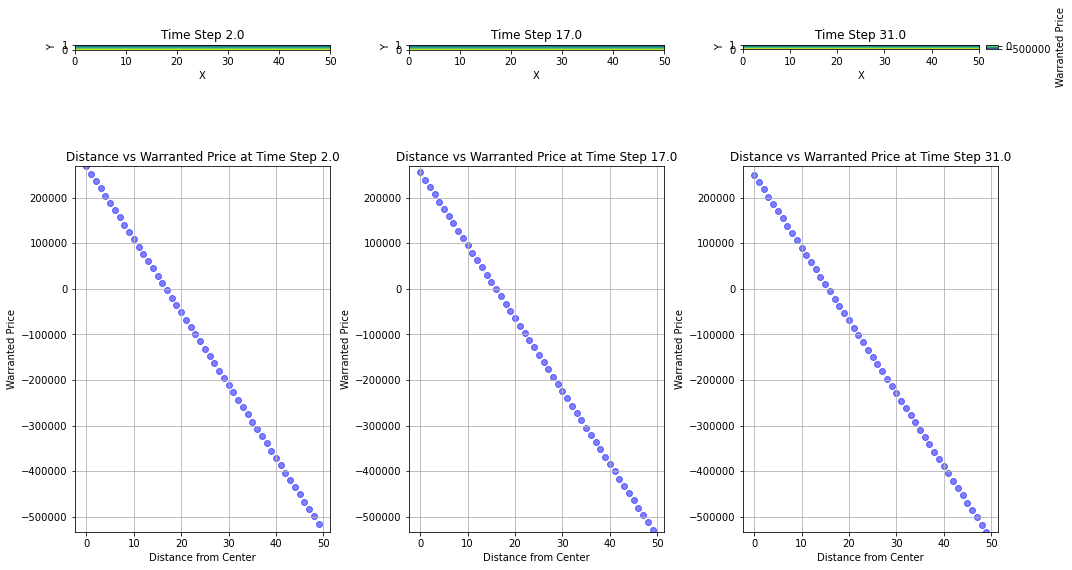

In [15]:
# Filter agent_out data for Land agents
df = agent_out.query("agent_type == 'Land'")
df = df.dropna(axis=1, how='all').reset_index(drop=True)
df = df.reset_index(drop=True)

# Get the range of time steps
time_steps = df['time_step'].unique()
num_time_steps = len(time_steps)
middle_time_step = time_steps[num_time_steps // 2]

# Find the overall min and max values for the color scale
min_price = df['warranted_price'].min()
max_price = df['warranted_price'].max()

# Create subplots with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Create a common colorbar axis
divider = make_axes_locatable(axs[0, -1])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Iterate over the subplots and time steps
for i, time_step in enumerate([time_steps[0], middle_time_step, time_steps[-1]]):
    land_agents = df.query("time_step == @time_step")
    
    # Create a grid to represent the space
    grid_size = (df['x'].max() + 1, df['y'].max() + 1)
    heatmap = np.zeros(grid_size)
    
    # Fill the heatmap with the values
    for index, row in land_agents.iterrows():
        x = int(row['x'])
        y = int(row['y'])
        price = row['warranted_price']
        heatmap[x, y] = price
    
    # Display the heatmap in the current subplot
    im = axs[0, i].imshow(heatmap, cmap='viridis', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]], vmin=min_price, vmax=max_price)
    axs[0, i].set_title(f'Time Step {time_step}')
    axs[0, i].set_xlabel('X')
    axs[0, i].set_ylabel('Y')
    axs[0, i].grid(False)
    
    # Create scatter plot for distance from center vs warranted price
    scatter = axs[1, i].scatter(land_agents['distance_from_center'], land_agents['warranted_price'], c='blue', alpha=0.5)
    axs[1, i].set_title(f'Distance vs Warranted Price at Time Step {time_step}')
    axs[1, i].set_xlabel('Distance from Center')
    axs[1, i].set_ylabel('Warranted Price')
    axs[1, i].grid(True)
    
    # Set same min and max values for scatter plots
    axs[1, i].set_ylim(min_price, max_price)

# Add a common colorbar
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Warranted Price')

plt.tight_layout()
plt.show()

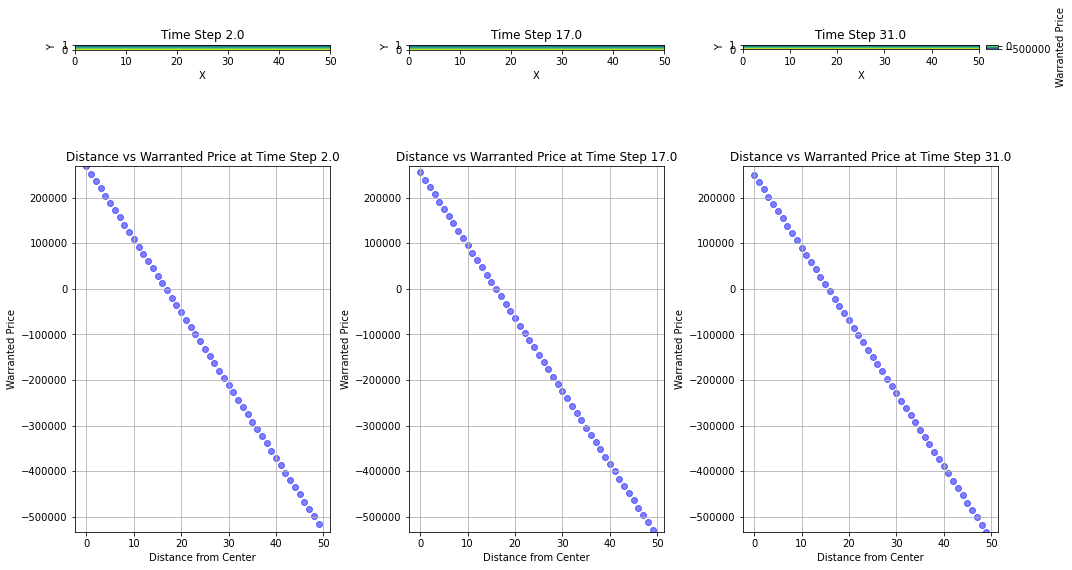

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming you have 'agent_out' DataFrame and relevant data columns

# Filter agent_out data for Land agents
df = agent_out.query("agent_type == 'Land'")
df = df.dropna(axis=1, how='all').reset_index(drop=True)
df = df.reset_index(drop=True)

# Get the range of time steps
time_steps = df['time_step'].unique()
num_time_steps = len(time_steps)
middle_time_step = time_steps[num_time_steps // 2]

# Find the overall min and max values for the color scale
min_price = df['warranted_price'].min()
max_price = df['warranted_price'].max()

# Create subplots with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Create a common colorbar axis
divider = make_axes_locatable(axs[0, -1])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Iterate over the subplots and time steps
for i, time_step in enumerate([time_steps[0], middle_time_step, time_steps[-1]]):
    land_agents = df.query("time_step == @time_step")
    
    # Create a grid to represent the space
    grid_size = (df['x'].max() + 1, df['y'].max() + 1)
    heatmap = np.zeros(grid_size)
    
    # Fill the heatmap with the values
    for index, row in land_agents.iterrows():
        x = int(row['x'])
        y = int(row['y'])
        price = row['warranted_price']
        heatmap[x, y] = price
    
    # Display the heatmap in the current subplot
    im = axs[0, i].imshow(heatmap, cmap='viridis', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]], vmin=min_price, vmax=max_price)
    axs[0, i].set_title(f'Time Step {time_step}')
    axs[0, i].set_xlabel('X')
    axs[0, i].set_ylabel('Y')
    axs[0, i].grid(False)
    
    # Create scatter plot for distance from center vs warranted price
    scatter = axs[1, i].scatter(land_agents['distance_from_center'], land_agents['warranted_price'], c='blue', alpha=0.5)
    axs[1, i].set_title(f'Distance vs Warranted Price at Time Step {time_step}')
    axs[1, i].set_xlabel('Distance from Center')
    axs[1, i].set_ylabel('Warranted Price')
    axs[1, i].grid(True)
    
    # Set same min and max values for scatter plots
    axs[1, i].set_ylim(min_price, max_price)

# Add a common colorbar
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Warranted Price')

plt.tight_layout()
plt.show()

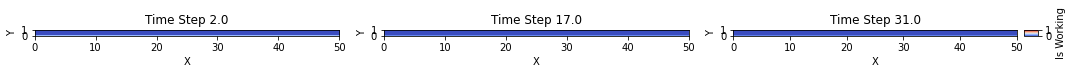

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming you have 'agent_out' DataFrame and relevant data columns

# Filter agent_out data for Land agents
df = agent_out.query("agent_type == 'Person'")
df = df.dropna(axis=1, how='all').reset_index(drop=True)
df = df.reset_index(drop=True)

# Get the range of time steps
time_steps = df['time_step'].unique()
num_time_steps = len(time_steps)
middle_time_step = time_steps[num_time_steps // 2]

# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over the subplots and time steps
for i, time_step in enumerate([time_steps[0], middle_time_step, time_steps[-1]]):
    land_agents = df.query("time_step == @time_step")
    
    # Create a grid to represent the space
    grid_size = (df['x'].max() + 1, df['y'].max() + 1)
    heatmap = np.zeros(grid_size)
    
    # Fill the heatmap with the 'is_working' values
    for index, row in land_agents.iterrows():
        x = int(row['x'])
        y = int(row['y'])
        is_working = row['is_working']
        heatmap[x, y] = is_working
    
    # Display the heatmap in the current subplot
    im = axs[i].imshow(heatmap, cmap='coolwarm', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]], vmin=0, vmax=1)
    axs[i].set_title(f'Time Step {time_step}')
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
    axs[i].grid(False)

# Add a common colorbar
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax, ticks=[0, 1])
cbar.set_label('Is Working')

plt.tight_layout()
plt.show()